# Import Library

In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import cv2
import glob
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def save_model(model):
    pickle.dump(model, open("./assets/coin_model.pkl", "wb"))


def load_model():
    return pickle.load(open("./assets/coin_model.pkl", "rb"))

# Functions and Classes

In [2]:
class Enum(tuple):
    __getattr__ = tuple.index


# Enumerate material types for use in classifier
Material = Enum(('Copper', 'Brass', 'Euro1', 'Euro2'))

# instantiate classifier (Multi-layer Perceptron)
CLF = MLPClassifier(solver="lbfgs")


def cal_histogram(image):
    mask = np.zeros(image.shape[:2], dtype="uint8")
    w, h = image.shape[1] // 2, image.shape[0] // 2
    cv2.circle(mask, (w, h), 60, 255, -1)

    # calcHist expects a list of images, color channels, mask, bins, ranges
    ranges = [0, 256, 0, 256, 0, 256]
    hist = cv2.calcHist([image], [0, 1, 2], mask, [8, 8, 8], ranges)

    # return normalized "flattened" histogram
    return cv2.normalize(hist, hist).flatten()


def cal_hist_from_file(file):
    image = cv2.imread(file)
    return cal_histogram(image)


# calculate feature vector for region of interest
def predict_material(roi):
    hist = cal_histogram(roi)

    # predict material type
    idx = CLF.predict([hist])

    # return predicted material type
    return Material[int(idx)]

# Read Images

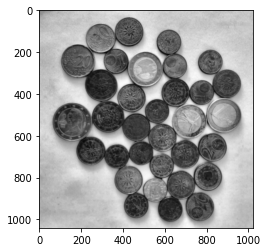

In [20]:
image = cv2.imread("./assetts/coinTest.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# create a copy of the image to display results
output = image.copy()

# convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# improve contrast accounting for differences in lighting conditions:
# create a CLAHE object to apply contrast limiting adaptive histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray  = clahe.apply(gray)

# reduce noise of the image, 0 to auto detected sigma
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

In [21]:
# locate sample image files
sample_images_copper = glob.glob("./assets/coin_sample_images/copper/*")
sample_images_brass  = glob.glob("./assets/coin_sample_images/brass/*")
sample_images_euro1  = glob.glob("./assets/coin_sample_images/euro1/*")
sample_images_euro2  = glob.glob("./assets/coin_sample_images/euro2/*")

# Size of sample images
print(f"Copper = {len(sample_images_copper):4} pictures")
print(f"Brass  = {len(sample_images_brass):4} pictures")
print(f"Euro 1 = {len(sample_images_euro1):4} pictures")
print(f"Euro 2 = {len(sample_images_euro2):4} pictures")

Copper =  170 pictures
Brass  =   32 pictures
Euro 1 =   29 pictures
Euro 2 =    6 pictures


# Training and Labeling

In [4]:
# define training data and labels
x = []
y = []

# compute and store training data and labels
for i in sample_images_copper:
    x.append(cal_hist_from_file(i))
    y.append(Material.Copper)

for i in sample_images_brass:
    x.append(cal_hist_from_file(i))
    y.append(Material.Brass)

for i in sample_images_euro1:
    x.append(cal_hist_from_file(i))
    y.append(Material.Euro1)

for i in sample_images_euro2:
    x.append(cal_hist_from_file(i))
    y.append(Material.Euro2)

# split samples into training (80 %) and test data (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

# train and score classifier
CLF.fit(x_train, y_train)
score = CLF.score(x_test, y_test) * 100
print(f"Classifier mean accuracy: {score:.2f}%")

Classifier mean accuracy: 95.83%


In [ ]:
save_model(CLF)

# Detect Coins

In [5]:
circles = cv2.HoughCircles(
    blurred, cv2.HOUGH_GRADIENT, dp=2.2, minDist=100,
    param1=200, param2=100, minRadius=50, maxRadius=120
)

diameters   = []
materials   = []
coordinates = []

if circles is not None:
    for x, y, r in circles[0, :]:
        diameters.append(r)

    # convert coordinates and radii to integers
    circles = np.round(circles[0, :]).astype("int")

    for x, y, d in circles:
        coordinates.append((x, y))

        # extract region of interest
        roi = image[y - d:y + d, x - d:x + d]

        # try recognition of material type and add result to list
        material = predict_material(roi)
        materials.append(material)

        # draw contour and results in the output image
        cv2.circle(output, (x, y), d, (0, 255, 0), 2)
        cv2.putText(
            output, material,
            (x - 40, y), cv2.FONT_HERSHEY_PLAIN,
            1.5, (0, 255, 0), thickness=2, lineType=cv2.LINE_AA
        )

# Get Biggest Diameters

In [7]:
biggest = max(diameters)
idx = diameters.index(biggest)

# scale everything according to maximum diameters
if materials[idx] == "Euro2":
    diameters = [d / biggest * 25.75 for d in diameters]
    scaledTo  = "Scaled to 2 Euro"

elif materials[idx] == "Brass":
    diameters = [d / biggest * 24.25 for d in diameters]
    scaledTo  = "Scaled to 50 Cent"

elif materials[idx] == "Euro1":
    diameters = [d / biggest * 23.25 for d in diameters]
    scaledTo  = "Scaled to 1 Euro"

elif materials[idx] == "Copper":
    diameters = [d / biggest * 21.25 for d in diameters]
    scaledTo  = "Scaled to 5 Cent"

else:
    scaledTo = "unable to scale.."

print(scaledTo)

Scaled to 5 Cent


# Write Output Image

In [8]:
total_vals = 0

for i in range(len(diameters)):
    x, y = coordinates[i]
    d = diameters[i]
    m = materials[i]
    coin_type = "Unknown"

    # compare to known diameters with some margin for error
    if math.isclose(d, 25.75, abs_tol=1.25) and m == "Euro2":
        coin_type  = "2 Euro"
        total_vals += 200
    elif math.isclose(d, 23.25, abs_tol=2.50) and m == "Euro1":
        coin_type  = "1 Euro"
        total_vals += 100
    elif math.isclose(d, 19.75, abs_tol=1.25) and m == "Brass":
        coin_type  = "10 Cent"
        total_vals += 10
    elif math.isclose(d, 22.25, abs_tol=1.00) and m == "Brass":
        coin_type  = "20 Cent"
        total_vals += 20
    elif math.isclose(d, 24.25, abs_tol=2.50) and m == "Brass":
        coin_type  = "50 Cent"
        total_vals += 50
    elif math.isclose(d, 16.25, abs_tol=1.25) and m == "Copper":
        coin_type  = "1 Cent"
        total_vals += 1
    elif math.isclose(d, 18.75, abs_tol=1.25) and m == "Copper":
        coin_type  = "2 Cent"
        total_vals += 2
    elif math.isclose(d, 21.25, abs_tol=2.50) and m == "Copper":
        coin_type  = "5 Cent"
        total_vals += 5

    # write result on output image
    cv2.putText(
        output, coin_type, (x - 40, y + 22), cv2.FONT_HERSHEY_PLAIN,
        1.5, (255, 255, 255), thickness=2, lineType=cv2.LINE_AA
    )

In [9]:
print(f"There are {len(diameters)} coins.")
print(f"Total amount of value is {total_vals} Cent.")

There are 33 coins.
Total amount of value is 60 Cent.


# Display Result

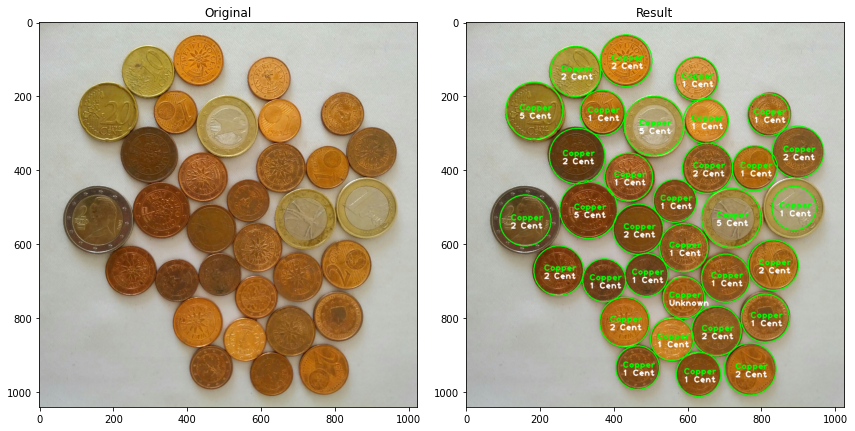

Scaled to 5 Cent
Coins detected: 33, EUR = 0.6 $
Classifier mean accuracy: 95.83%


In [12]:
# show result of the detected coins
fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original')

fig.add_subplot(1, 2, 2)
plt.imshow(output)
plt.title('Result')

plt.tight_layout()
plt.show()

# write summary on output image
print(scaledTo)
print(f"Coins detected: {len(diameters)}, EUR = {total_vals / 100} $")
print(f"Classifier mean accuracy: {score:.2f}%")